[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='In addition to whales, there are several fascinating ocean mammals you might want to explore:\n\n1. **Dolphins** - Closely related to whales, dolphins are highly intelligent and social creatures found in oceans worldwide.\n\n2. **Porpoises** - Similar to dolphins but generally smaller and with different facial features and behaviors.\n\n3. **Seals** - Marine mammals that are part of the pinniped family, often seen lounging on coastal shores or rocks.\n\n4. **Sea Lions** - Known for their external ear flaps and ability to "walk" on land using their large flippers, unlike seals.\n\n5. **Walruses** - Recognized for their long tusks and bulky bodies, walruses are typically found in Arctic regions.\n\n6. **Manatees** - Sometimes called "sea cows," these gentle herbivores are found in shallow coastal areas and are essential to healthy seagrass ecosystems.\n\n7. **Dugongs** - Closely related to manatees, dugongs are found in warm coastal waters from East Africa to Australia

We can run our chat model in a simple graph with `MessagesState`.

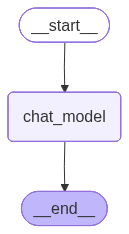

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to learn about:

1. **Dolphins:** Highly intelligent, social creatures known for their playful behavior and acrobatics. There are numerous species, including the common bottlenose dolphin and the distinctive-looking orca, which is the largest member of the dolphin family.

2. **Porpoises:** Similar to dolphins but generally smaller and with different facial structures and teeth. One well-known species is the harbor porpoise.

3. **Seals:** These pinnipeds are divided into two families: the earless (true) seals, such as the har

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

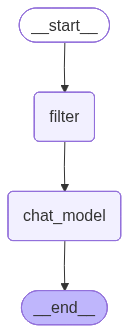

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals beyond whales that you might want to learn about:

1. **Dolphins:** Known for their intelligence and playful behavior, dolphins are highly social creatures found in many of the world's oceans. 

2. **Porpoises:** Similar to dolphins but generally smaller and stouter, porpoises are less common and tend to be more shy around humans.

3. **Seals and Sea Lions:** These pinnipeds are often seen lounging on beaches and rocks. Seals are generally more reserved, while sea lions are known for their barking communication and more social behavior.

4. **Walruses:** Large and recog

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

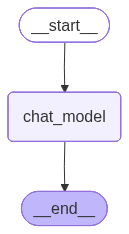

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals beyond whales that you might want to learn about:

1. **Dolphins:** Known for their intelligence and playful behavior, dolphins are highly social creatures found in many of the world's oceans. 

2. **Porpoises:** Similar to dolphins but generally smaller and stouter, porpoises are less common and tend to be more shy around humans.

3. **Seals and Sea Lions:** These pinnipeds are 

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are several fascinating ocean mammals beyond whales that you might want to learn about:

1. **Dolphins:** Known for their intelligence and playful behavior, dolphins are highly social creatures found in many of the world's oceans. 

2. **Porpoises:** Similar to dolphins but generally smaller and stouter, porpoises are less common and tend to be more shy around humans.

3. **Seals and Sea Lions:** These pinnipeds are 

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

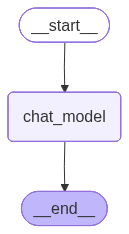

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

In [18]:
# modifications made below, before making my own example, I wanted to test out if I allow partial trimming, whether langsmith website shows multiple messages

In [19]:
# Changing allow partial to be True
messages=trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=True
        )


In [20]:
# Invoking using the trimmed messages
messages_out_trim = graph.invoke({'messages': messages})

In [21]:
# Langsmith website did show multiple messsages as input to the AI model


In [22]:
# making a new conversation

In [23]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
conversation = [AIMessage(f"What do you want me to help you with?", name="Bot")]
conversation.append(HumanMessage(f"I want to know more about RAM in a computer. Can you give me more details about it?", name="Anshul"))

for m in conversation:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

What do you want me to help you with?
================================ Human Message =================================
Name: Anshul

I want to know more about RAM in a computer. Can you give me more details about it?


In [24]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(conversation)

AIMessage(content="Certainly! RAM, or Random Access Memory, is a crucial component of a computer that plays a significant role in its performance. Here are some key details about RAM:\n\n1. **Function**: RAM temporarily stores data that the CPU needs to access quickly. It is used for active tasks and the current workload being handled by the computer, such as running applications and the operating system.\n\n2. **Volatility**: RAM is volatile memory, meaning it loses all stored information when the computer is turned off. This is why data from RAM must be saved to a non-volatile storage solution (like an HDD or SSD) if you want to keep it after shutting down the system.\n\n3. **Speed and Performance**: The speed of RAM is measured in MHz or GHz, and it affects how quickly data can be read from or written to it. Faster RAM can improve the performance of your computer, particularly for tasks like gaming, video editing, or handling large datasets.\n\n4. **Capacity**: The capacity of RAM i

In [25]:
# now we have our own conversation. now adding a reducer which takes in the last 2 ,messages

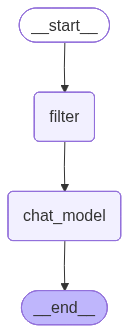

In [26]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
# using the previous conversation
conversation = [AIMessage(f"What do you want me to help you with?", name="Bot", id="1")]
conversation.append(HumanMessage(f"I want to know more about RAM in a computer. Can you give me more details about it?", name="Anshul",id="2"))
conversation.append(HumanMessage(f"How much do you know about cache?", name="Bot",id="3"))
conversation.append(HumanMessage(f"I don't know about caches, please do take that into consideration", name="Anshul",id="4"))

# Invoke
output = graph.invoke({'messages': conversation})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Bot

How much do you know about cache?
================================ Human Message =================================
Name: Anshul

I don't know about caches, please do take that into consideration
================================== Ai Message ==================================

No worries! Let's break it down.

A **cache** is a hardware or software component that stores data so that future requests for that data can be served faster. The data stored in a cache might be the result of an earlier computation or a copy of data stored elsewhere. Here are some key aspects of caches:

1. **Purpose**: The primary purpose of a cache is to improve data retrieval speed. By keeping frequently accessed data in a location that's quicker to access than the original source, systems can run more efficiently.

2. **Types**:
   - **Memory Cache**: Often found in CPUs, it's a small amount of faster memory that stores

In [28]:
# here we can see that the bot wasn't aware that my initial question was on RAM and it proceeded to answer only about cache

In [29]:
# filtering is similar to a reducer, but it takes in only the last message. and while displaying, it displays the entire converation.

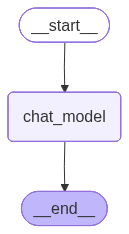

In [30]:
# Using the same graph
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
conversation.append(output['messages'][-1])
conversation.append(HumanMessage(f"Tell me more about caches", name="Anshul"))

for c in conversation:
    c.pretty_print()

================================== Ai Message ==================================
Name: Bot

What do you want me to help you with?
================================ Human Message =================================
Name: Anshul

I want to know more about RAM in a computer. Can you give me more details about it?
================================ Human Message =================================
Name: Bot

How much do you know about cache?
================================ Human Message =================================
Name: Anshul

I don't know about caches, please do take that into consideration
================================== Ai Message ==================================

No worries! Let's break it down.

A **cache** is a hardware or software component that stores data so that future requests for that data can be served faster. The data stored in a cache might be the result of an earlier computation or a copy of data stored elsewhere. Here are some key aspects of caches:

1. **Purpose**: 

In [32]:
output = graph.invoke({'messages': conversation})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

What do you want me to help you with?
================================ Human Message =================================
Name: Anshul

I want to know more about RAM in a computer. Can you give me more details about it?
================================ Human Message =================================
Name: Bot

How much do you know about cache?
================================ Human Message =================================
Name: Anshul

I don't know about caches, please do take that into consideration
================================== Ai Message ==================================

No worries! Let's break it down.

A **cache** is a hardware or software component that stores data so that future requests for that data can be served faster. The data stored in a cache might be the result of an earlier computation or a copy of data stored elsewhere. Here are some key aspects of caches:

1. **Purpose**: 

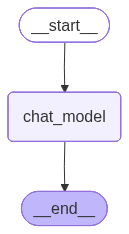

In [33]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    conversation = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
#adding this random question from a different conversation and then seeing how the model answers it
conversation.append(output['messages'][-1])
conversation.append(HumanMessage(f"Tell me where Orcas live!", name="Anshul"))

In [35]:
# Example of trimming messages
trimmed_conversation=trim_messages(
            conversation,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

In [36]:
messages_out_trim = graph.invoke({'messages': trimmed_conversation})

In [37]:
# as expected, the model simply answered question about orcas without any context given. next trying out when allow partial is true

In [38]:
# Example of trimming messages
trimmed_conversation=trim_messages(
            conversation,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=True
        )

In [39]:
messages_out_trim = graph.invoke({'messages': trimmed_conversation})

In [40]:
# since the question was too direct, the model still answers only about orcas, but in input, we can see context about cache visible from the image